<a href="https://colab.research.google.com/github/helloiamching/1217-lab/blob/main/ST5218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Set up

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
import time
from tqdm import tqdm

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
#weather_data = pd.read_csv('weather_station_data.csv')
#passengervolumne = pd.read_csv('/content/PassengerVolume+coordinates(202411).csv')
df_train = pd.read_csv('/content/drive/MyDrive/weather_data/Final_MRT.csv')
df_test = pd.read_csv('/content/drive/MyDrive/weather_data/ridership_202501.csv')
# df_all = pd.concat([df, df_val], axis=0)
#population_data = pd.read_csv('population.csv')


# Data Cleaning

In [16]:
df_train = df_train.drop('is_transfer_hub', axis = 1)
df_test = df_test.drop('total_ridership', axis = 1)

df_test = df_test.rename(columns={
    'day_type': 'is_holiday',
    'latitude': 'Latitude',
    'longitude': 'Longitude'
})

df_test['is_holiday'] = df_test['is_holiday'].map({
    'WEEKENDS/HOLIDAY': 1,
    'WEEKDAY': 0
})

In [17]:
print(f"Train data has {df_train.shape[0]} rows with {sorted(list(df_train.columns))} features")
print(f"Test data has {df_test.shape[0]} rows with {sorted(list(df_test.columns))} features")

Train data has 219833 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features
Test data has 111919 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features


In [35]:
def process_passenger_volume(df, split_weekend = True):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d %H:%M')
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df = df.dropna(subset=['tap_in'])

    if split_weekend:
      weekday_data = df[df['is_holiday'] == 0]
      weekend_data = df[df['is_holiday'] == 1]
      return weekday_data, weekend_data

    else:
      return df

# Step 1: Merge data

In [ ]:
# def prepare_data(passengervolume_df, weather_df):

#     passenger_df = passengervolume_df.copy()
#     weather_df_copy = weather_df.copy()
#     direct_match_df = passenger_df.merge(weather_df_copy, on=['station_id', 'month', 'hour'], how='left')
#     direct_match_df['year'] = direct_match_df['year_x']
#     selected = ['station_id', 'year', 'month','hour','TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME','geometry','Latitude','Longitude','air_temperature','relative_humidity','wind_speed','rainfall' ]
#     direct_match_df = direct_match_df[selected]

#     stations_missing_weather = direct_match_df[direct_match_df['air_temperature'].isna()].copy()

#     if not stations_missing_weather.empty:
#         print(f"Applying kernel smoothing for {len(stations_missing_weather)} records without direct weather data")

#         for (yr, mo, hr), time_group in stations_missing_weather.groupby(['year', 'month', 'hour']):
#             current_weather = weather_df_copy[
#                 (weather_df_copy['year'] == yr) &
#                 (weather_df_copy['month'] == mo) &
#                 (weather_df_copy['hour'] == hr)
#             ]

#             if not current_weather.empty:
#                 for idx, station in time_group.iterrows():
#                     weather_coords = current_weather[['latitude', 'longitude']].values
#                     station_coord = np.array([[station['Latitude'], station['Longitude']]])
#                     distances = cdist(station_coord, weather_coords, 'euclidean').flatten()

#                     # Gaussian kernel
#                     bandwidth = 0.05 #Test: 0.05
#                     weights = np.exp(-(distances**2) / (2 * bandwidth**2))
#                     weights = weights / weights.sum()

#                     # Apply weighted average for each weather feature
#                     for col in ['air_temperature', 'relative_humidity', 'wind_speed', 'rainfall']:
#                         if col in current_weather.columns:
#                             values = current_weather[col].values
#                             # Filter out NaN values before calculating weighted average
#                             valid_indices = ~np.isnan(values)
#                             if np.any(valid_indices):
#                                 filtered_values = values[valid_indices]
#                                 filtered_weights = weights[valid_indices]
#                                 # Normalize weights again after filtering
#                                 filtered_weights = filtered_weights / filtered_weights.sum()
#                                 # Calculate weighted average
#                                 weighted_avg = np.sum(filtered_values * filtered_weights)
#                                 direct_match_df.loc[idx, col] = weighted_avg

#     # Handle any remaining missing values with column means
#     numeric_cols = ['air_temperature', 'relative_humidity', 'wind_speed', 'rainfall']
#     for col in numeric_cols:
#         if col in direct_match_df.columns:
#             col_mean = direct_match_df[col].mean()
#             direct_match_df[col] = direct_match_df[col].fillna(col_mean)

#     return direct_match_df

# Step 2: Create graph structure

In [ ]:
# node_features, edge_index, edge_attr, node_mapping = create_graph_data(df)

In [36]:
def create_graph_data(merged_df):
    stations = merged_df[['station_id', 'Latitude', 'Longitude']].drop_duplicates()
    node_features = []
    node_mapping = {}

    for idx, (_, station) in enumerate(stations.iterrows()):
        node_mapping[station['station_id']] = idx
        node_features.append([station['Latitude'], station['Longitude']])
    edge_index = []
    edge_attr = []

    k = 5
    for i, (_, station_i) in enumerate(stations.iterrows()):
        distances = []
        for j, (_, station_j) in enumerate(stations.iterrows()):
            if i != j:
                dist = np.sqrt((station_i['Latitude'] - station_j['Latitude'])**2 +
                              (station_i['Longitude'] - station_j['Longitude'])**2)
                distances.append((j, dist))

        distances.sort(key=lambda x: x[1])
        for j, dist in distances[:k]:
            edge_index.append([i, j])
            edge_attr.append([dist])

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return node_features, edge_index, edge_attr, node_mapping


# Step 3 : Time series features and targets

In [37]:
def prepare_time_series_data(merged_df, node_mapping, lags=2):
  if len(merged_df['is_holiday'].unique()) != 2:
    features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall']
    targets = ['tap_in', 'tap_out']
  else:
    features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday']
    targets = ['tap_in', 'tap_out']


  scaler_X = StandardScaler()
  scaler_y = StandardScaler()

  X = []
  y = []
  station_indices = []

  for station_id, group in merged_df.groupby('station_id'):
      if station_id not in node_mapping:
         continue
      node_idx = node_mapping[station_id]
      group = group.sort_values('timestamp')

      group = group[features + targets].fillna(0)  # Replace NA with 0

      if group[features].std().sum() == 0:
         print(f"⚠ Warning: Station {station_id} has constant feature values. Skipping...")
         continue

      station_X_base = group[features].values
      station_y = group[targets].values

      lag_features = []
      for lag in range(1, lags + 1):
         lagged = group[targets].shift(lag).fillna(0).values  # Shift and fill NaNs with 0
         lag_features.append(lagged)

      lag_features = np.hstack(lag_features)
      station_X = np.hstack([station_X_base, lag_features])  # Shape: [time_steps, len(features) + lags * len(targets)]
      station_X_scaled = scaler_X.fit_transform(station_X)
      station_y_scaled = scaler_y.fit_transform(station_y)

      station_X_scaled = station_X_scaled[lags:]
      station_y_scaled = station_y_scaled[lags:]

      X.append(station_X_scaled)
      y.append(station_y_scaled)
      station_indices.extend([node_idx] * len(station_X_scaled))

  X = torch.tensor(np.nan_to_num(np.vstack(X), nan=0.0), dtype=torch.float)
  y = torch.tensor(np.nan_to_num(np.vstack(y), nan=0.0), dtype=torch.float)
  station_indices = torch.tensor(station_indices, dtype=torch.long)

  print(f"Data Prepared: X shape {X.shape}, y shape {y.shape}, Stations: {len(set(station_indices.tolist()))}")

  return X, y, station_indices, scaler_X, scaler_y

# Step 4:  Define GNN model

In [38]:
class PassengerVolumeGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, out_channels, time_feature_size=7):
        super(PassengerVolumeGNN, self).__init__()
        self.time_feature_size = time_feature_size
        self.conv1 = GATConv(node_features, hidden_channels, heads=4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.sage = SAGEConv(hidden_channels, hidden_channels)

        self.time_rnn = torch.nn.GRU(time_feature_size, hidden_channels, batch_first=True)
        self.time_lin1 = torch.nn.Linear(hidden_channels + hidden_channels, hidden_channels)
        self.time_lin2 = torch.nn.Linear(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, time_features, batch_indices):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training) # 紀錄 drop out 嘗試結果，可寫進報告裡 ex, 0.2, 0.1 0.05
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.sage(x, edge_index)
        x = F.relu(x)

        time_out, _ = self.time_rnn(time_features.view(-1, 1, self.time_feature_size))
        time_out = time_out.squeeze(1)

        node_embeddings = x[batch_indices]
        combined = torch.cat([node_embeddings, time_out], dim=1)

        combined = self.time_lin1(combined)
        combined = F.relu(combined)
        combined = F.dropout(combined, p=0.05, training=self.training)
        combined = self.time_lin2(combined)
        combined = F.relu(combined)

        out = self.lin(combined)
        return out

# Training function

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

def train_model(
    model, node_features, edge_index, edge_attr,
    X_train, y_train, station_indices_train,
    X_val, y_val, station_indices_val,
    epochs=500, patience=20, lr=0.001
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        y_pred_train = model(node_features.to(device), edge_index.to(device), edge_attr.to(device), X_train.to(device), station_indices_train.to(device))
        loss = loss_fn(y_pred_train, y_train.to(device))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # val
        model.eval()
        with torch.no_grad():
            y_pred_val = model(node_features.to(device), edge_index.to(device), edge_attr.to(device), X_val.to(device), station_indices_val.to(device))
            val_loss = loss_fn(y_pred_val, y_val.to(device))
            val_losses.append(val_loss.item())

        # Early stopping
        if val_loss.item() < best_val_loss - 1e-4:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses


In [40]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_predictions(y_pred, y_true, num_samples=100):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true[:num_samples, 0], label="Actual", marker='o')
    plt.plot(y_pred[:num_samples, 0], label="Predicted", marker='x')
    plt.xlabel("Sample")
    plt.ylabel("Passenger Volume")
    plt.title("Actual vs Predicted (Test Samples)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [41]:
from sklearn.metrics import explained_variance_score
import numpy as np

from sklearn.metrics import explained_variance_score
import numpy as np
import torch

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.where(denominator == 0, 1e-10, denominator)
    return np.mean(diff) * 100

def mase(y_true, y_pred, y_train, seasonality=1):
    n = y_train.shape[0]
    d = np.abs(y_train[seasonality:] - y_train[:-seasonality]).mean()
    errors = np.abs(y_true - y_pred)
    return errors.mean() / (d + 1e-10)

def evaluate_model(model, node_features, edge_index, edge_attr,
                   X_test, y_test, station_indices_test, scaler_y, y_train=None):
    model.eval()
    with torch.no_grad():
        out = model(node_features, edge_index, edge_attr, X_test, station_indices_test)

    y_pred = scaler_y.inverse_transform(out.cpu().numpy())
    y_true = scaler_y.inverse_transform(y_test.cpu().numpy())

    # Regression metrics
    mse = ((y_pred - y_true) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(y_pred - y_true).mean()
    r2 = 1 - ((y_true - y_pred) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum()
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100
    smape_val = smape(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)

    # MASE requires y_train
    if y_train is not None:
        y_train = scaler_y.inverse_transform(y_train.cpu().numpy())
        mase_val = mase(y_true, y_pred, y_train)
    else:
        mase_val = None

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape_val:.2f}%")
    print(f"Test R²: {r2:.4f}")
    print(f"Explained Variance Score: {evs:.4f}")
    if mase_val is not None:
        print(f"Test MASE: {mase_val:.4f}")
    else:
        print("MASE could not be calculated (y_train not provided)")

    return y_pred, y_true

def evaluate_combined_model(df, weekday_model, weekend_model,
                            node_features_wd, edge_index_wd, edge_attr_wd, scaler_y_wd,
                            node_features_we, edge_index_we, edge_attr_we, scaler_y_we,
                            X, y, station_indices):
    y_preds = []
    y_trues = []

    for i in range(len(X)):
        x_sample = X[i:i+1]  # Keep it as 2D
        y_sample = y[i:i+1]
        station_sample = station_indices[i:i+1]

        if df.iloc[i]['is_holiday'] == 1:
            pred, _ = evaluate_model(weekend_model, node_features_we, edge_index_we, edge_attr_we,
                                     x_sample, y_sample, station_sample, scaler_y_we)
        else:
            pred, _ = evaluate_model(weekday_model, node_features_wd, edge_index_wd, edge_attr_wd,
                                     x_sample, y_sample, station_sample, scaler_y_wd)

        y_preds.append(pred)
        y_trues.append(y_sample)

    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)

    plot_predictions(y_preds, y_trues)
    return y_preds, y_trues


def plot_losses(train_losses, val_losses, tag=""):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linewidth=2)

    plt.title(f'Training and Validation Loss Over Epochs ({tag.upper()})', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


In [52]:
def main(df_train, df_test, tag="all"):
    start_time = time.time()

    # 1. Graph Creation
    print("1. Creating graph structure...")
    graph_start = time.time()
    node_features, edge_index, edge_attr, node_mapping = create_graph_data(df_train)
    print(f" Graph creation completed in {time.time() - graph_start:.2f} seconds.")

    # 2. Time Series Preparation
    print("2. Preparing time series data...")
    ts_start = time.time()
    X_train, y_train, station_indices_train, scaler_X_train, scaler_y_train = prepare_time_series_data(df_train, node_mapping)
    X_test, y_test, station_indices_test, scaler_X_test, scaler_y_test = prepare_time_series_data(df_test, node_mapping)
    print(f"Time series preparation completed in {time.time() - ts_start:.2f} seconds.")

    # 3. Data Splitting
    print("3. Splitting dataset...")
    split_start = time.time()
    indices = np.arange(len(X_train))
    idx_train, idx_val = train_test_split(indices, test_size=0.2, shuffle = False)
    # idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=42)

    X_val, y_val = X_train[idx_val], y_train[idx_val]
    X_train, y_train = X_train[idx_train], y_train[idx_train]
    # X_test, y_test = X[idx_test], y[idx_test]

    station_indices_val = station_indices_train[idx_val]
    station_indices_train = station_indices_train[idx_train]
    # station_indices_test = station_indices[idx_test]
    print(f" Data split completed in {time.time() - split_start:.2f} seconds.")

    # 4. Model Initialization
    print("4. Initializing GNN model...")
    model_start = time.time()
    model = PassengerVolumeGNN(
        node_features=node_features.shape[1],
        hidden_channels=64,
        out_channels=2,
        time_feature_size=X_train.shape[1]
    )
    print(f" Model initialization completed in {time.time() - model_start:.2f} seconds.")

    # 5. Training
    print("5. Training model...")
    train_start = time.time()
    train_losses, val_losses = train_model(
        model, node_features, edge_index, edge_attr,
        X_train, y_train, station_indices_train,
        X_val, y_val, station_indices_val,
        epochs=300
    )
    print(f" Training completed in {time.time() - train_start:.2f} seconds.")

    # 6. Evaluation
    print("6. Evaluating model...")
    eval_start = time.time()
    y_pred, y_true = evaluate_model(
        model, node_features, edge_index, edge_attr,
        X_test, y_test, station_indices_test, scaler_y_test
    )
    plot_predictions(y_pred, y_true)
    print(f"Evaluation completed in {time.time() - eval_start:.2f} seconds.")

    # 7. Plot Losses for this model
    print(f"Plotting losses for {tag} model...")
    plot_losses(train_losses, val_losses, tag=tag)

    total_time = time.time() - start_time
    print(f"{tag.upper()} completed in {total_time:.2f} seconds.\n")

    return model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping

1. Creating graph structure...
 Graph creation completed in 1.86 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([151067, 9]), y shape torch.Size([151067, 2]), Stations: 181
Data Prepared: X shape torch.Size([71858, 9]), y shape torch.Size([71858, 2]), Stations: 181
Time series preparation completed in 1.95 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.01 seconds.
5. Training model...


100%|██████████| 120/120 [02:11<00:00,  1.10s/it]


 Training completed in 131.56 seconds.
6. Evaluating model...
Test MSE: 7268460.5000
Test RMSE: 2696.0083
Test MAE: 1837.5403
Test MAPE: 72.01%
Test SMAPE: 24.08%
Test R²: 0.7648
Explained Variance Score: 0.7668
MASE could not be calculated (y_train not provided)


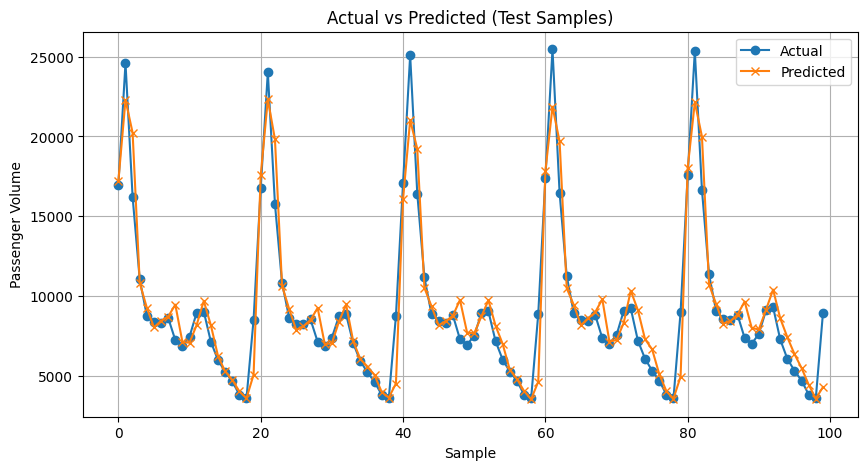

Evaluation completed in 0.55 seconds.
Plotting losses for weekday model...


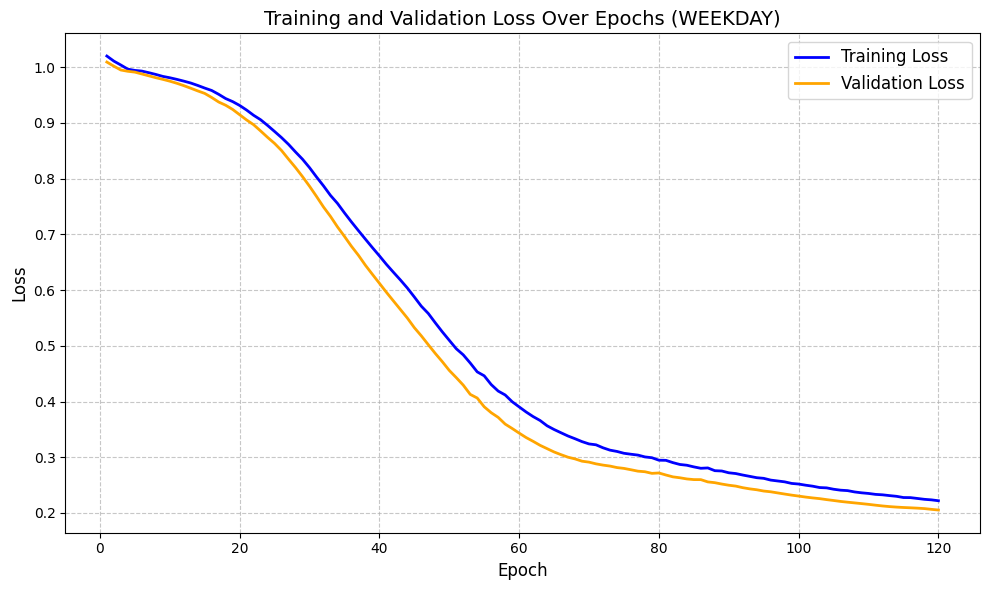

WEEKDAY completed in 136.31 seconds.

1. Creating graph structure...
 Graph creation completed in 2.13 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([68029, 9]), y shape torch.Size([68029, 2]), Stations: 181
Data Prepared: X shape torch.Size([39337, 9]), y shape torch.Size([39337, 2]), Stations: 181
Time series preparation completed in 1.78 seconds.
3. Splitting dataset...
 Data split completed in 0.00 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 120/120 [00:55<00:00,  2.18it/s]


 Training completed in 55.04 seconds.
6. Evaluating model...
Test MSE: 751383.5625
Test RMSE: 866.8239
Test MAE: 640.2568
Test MAPE: 129.12%
Test SMAPE: 27.37%
Test R²: 0.8369
Explained Variance Score: 0.8355
MASE could not be calculated (y_train not provided)


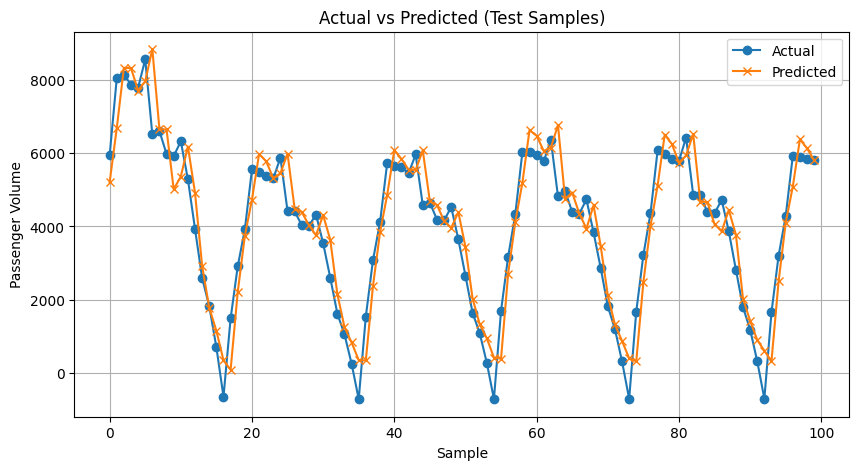

Evaluation completed in 0.28 seconds.
Plotting losses for weekend model...


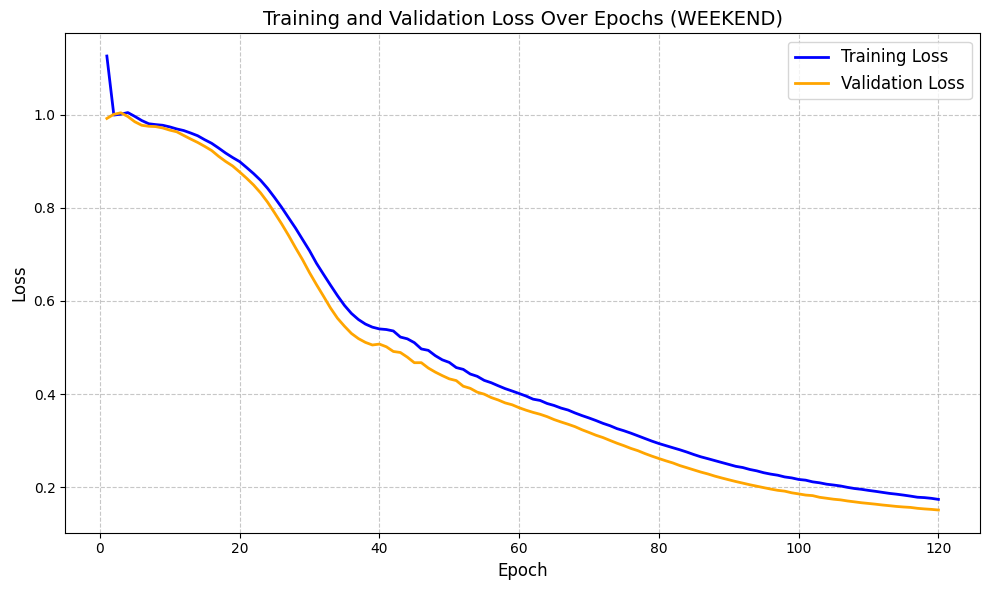

WEEKEND completed in 59.46 seconds.



In [43]:
train_weekday_data, train_weekend_data = process_passenger_volume(df_train)
test_weekday_data, test_weekend_data = process_passenger_volume(df_test)

weekday_model, scaler_X_wd_train, scaler_y_wd_train, scaler_X_wd_test, scaler_y_wd_test, node_mapping_wd = main(train_weekday_data, test_weekday_data, tag="weekday")
weekend_model, scaler_X_we, scaler_y_we, scaler_X_we_test, scaler_y_we_test, node_mapping_we = main(train_weekend_data, test_weekend_data, tag="weekend")

1. Creating graph structure...
 Graph creation completed in 1.87 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([219458, 10]), y shape torch.Size([219458, 2]), Stations: 181
Data Prepared: X shape torch.Size([111557, 10]), y shape torch.Size([111557, 2]), Stations: 181
Time series preparation completed in 2.03 seconds.
3. Splitting dataset...
 Data split completed in 0.02 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.01 seconds.
5. Training model...


100%|██████████| 120/120 [04:27<00:00,  2.23s/it]


 Training completed in 267.59 seconds.
6. Evaluating model...
Test MSE: 5762715.0000
Test RMSE: 2400.5657
Test MAE: 1487.8451
Test MAPE: 45.55%
Test SMAPE: 23.25%
Test R²: 0.7944
Explained Variance Score: 0.7954
MASE could not be calculated (y_train not provided)


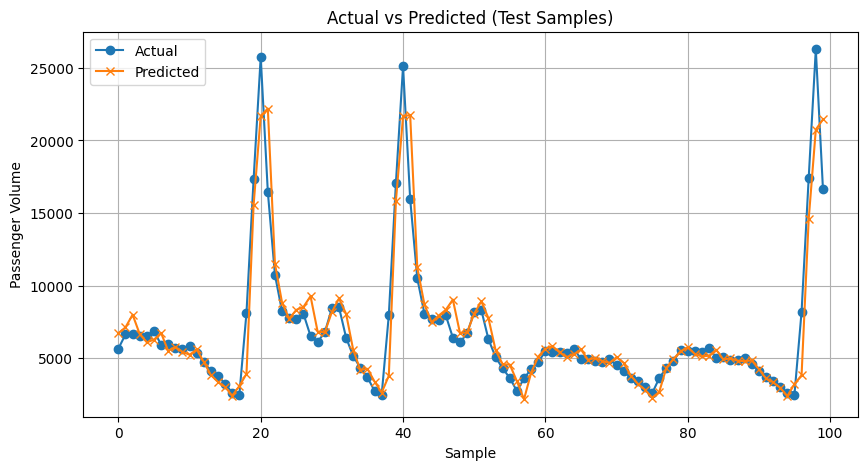

Evaluation completed in 0.75 seconds.
Plotting losses for all_variable model...


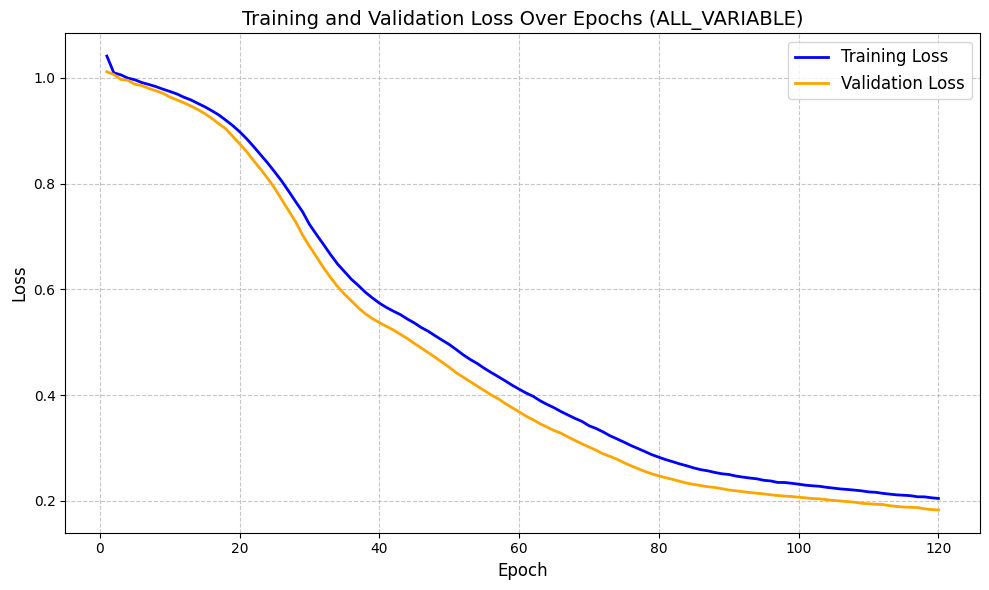

ALL_VARIABLE completed in 272.55 seconds.



In [44]:
df_train_clean_variable = process_passenger_volume(df_train, False)
df_test_clean_variable = process_passenger_volume(df_test, False)
all_model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping = main(df_train_clean_variable, df_test_clean_variable, tag="all_variable")

# In case we need to use all variables

In [45]:
def is_transfer_hub(station_id):
    if '/' in str(station_id):
        return 1
    else:
        return 0

In [46]:
df_train['is_transfer_hub'] = df_train['station_id'].apply(is_transfer_hub)
df_test['is_transfer_hub'] = df_test['station_id'].apply(is_transfer_hub)

In [47]:
print(f"Train data has {df_train.shape[0]} rows with {sorted(list(df_train.columns))} features")
print(f"Test data has {df_test.shape[0]} rows with {sorted(list(df_test.columns))} features")

Train data has 219833 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'is_transfer_hub', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features
Test data has 111919 rows with ['Latitude', 'Longitude', 'Visitors', 'air_temperature', 'is_holiday', 'is_transfer_hub', 'rainfall', 'relative_humidity', 'station_id', 'tap_in', 'tap_out', 'timestamp', 'wind_speed'] features


In [48]:
def prepare_time_series_data(merged_df, node_mapping, lags=2):
  if len(merged_df['is_holiday'].unique()) != 2:
    features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall','Visitors','is_transfer_hub']
    targets = ['tap_in', 'tap_out']
  else:
    features = ['hour', 'air_temperature', 'relative_humidity', 'wind_speed', 'rainfall', 'is_holiday','Visitors','is_transfer_hub']
    targets = ['tap_in', 'tap_out']


  scaler_X = StandardScaler()
  scaler_y = StandardScaler()

  X = []
  y = []
  station_indices = []

  for station_id, group in merged_df.groupby('station_id'):
      if station_id not in node_mapping:
         continue
      node_idx = node_mapping[station_id]
      group = group.sort_values('timestamp')

      group = group[features + targets].fillna(0)  # Replace NA with 0

      if group[features].std().sum() == 0:
         print(f"⚠ Warning: Station {station_id} has constant feature values. Skipping...")
         continue

      station_X_base = group[features].values
      station_y = group[targets].values

      lag_features = []
      for lag in range(1, lags + 1):
         lagged = group[targets].shift(lag).fillna(0).values  # Shift and fill NaNs with 0
         lag_features.append(lagged)

      lag_features = np.hstack(lag_features)
      station_X = np.hstack([station_X_base, lag_features])  # Shape: [time_steps, len(features) + lags * len(targets)]
      station_X_scaled = scaler_X.fit_transform(station_X)
      station_y_scaled = scaler_y.fit_transform(station_y)

      station_X_scaled = station_X_scaled[lags:]
      station_y_scaled = station_y_scaled[lags:]

      X.append(station_X_scaled)
      y.append(station_y_scaled)
      station_indices.extend([node_idx] * len(station_X_scaled))

  X = torch.tensor(np.nan_to_num(np.vstack(X), nan=0.0), dtype=torch.float)
  y = torch.tensor(np.nan_to_num(np.vstack(y), nan=0.0), dtype=torch.float)
  station_indices = torch.tensor(station_indices, dtype=torch.long)

  print(f"Data Prepared: X shape {X.shape}, y shape {y.shape}, Stations: {len(set(station_indices.tolist()))}")

  return X, y, station_indices, scaler_X, scaler_y

1. Creating graph structure...
 Graph creation completed in 3.03 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([151067, 11]), y shape torch.Size([151067, 2]), Stations: 181
Data Prepared: X shape torch.Size([71858, 11]), y shape torch.Size([71858, 2]), Stations: 181
Time series preparation completed in 1.97 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 120/120 [02:09<00:00,  1.08s/it]


 Training completed in 129.51 seconds.
6. Evaluating model...
Test MSE: 7448754.5000
Test RMSE: 2729.2407
Test MAE: 1850.6174
Test MAPE: 94.58%
Test SMAPE: 24.12%
Test R²: 0.7589
Explained Variance Score: 0.7616
MASE could not be calculated (y_train not provided)


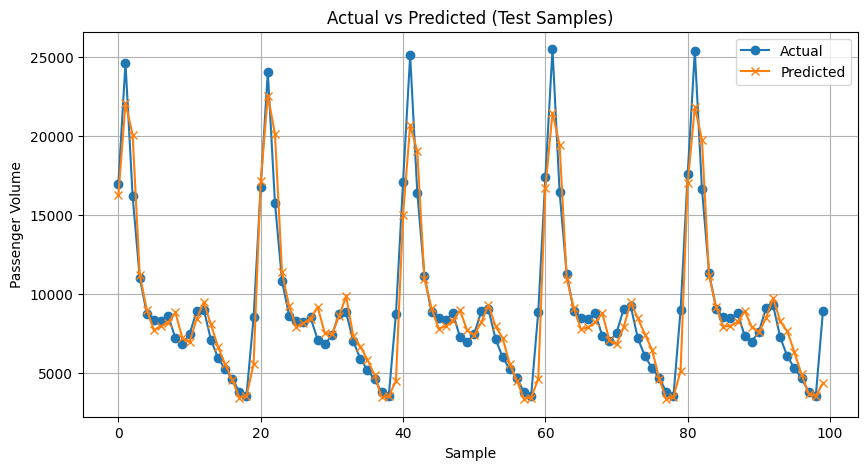

Evaluation completed in 0.38 seconds.
Plotting losses for weekday model...


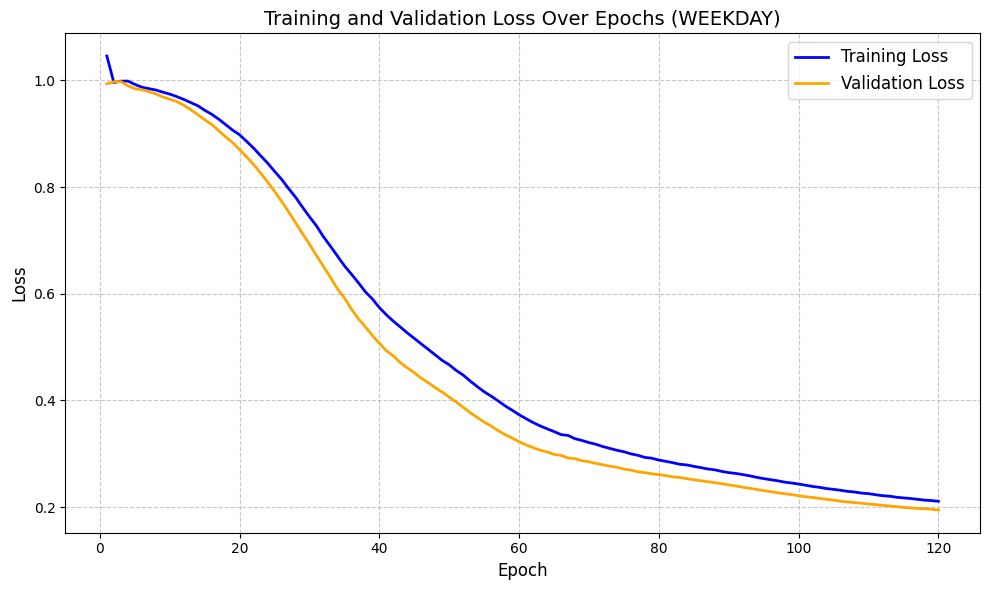

WEEKDAY completed in 135.12 seconds.

1. Creating graph structure...
 Graph creation completed in 1.86 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([68029, 11]), y shape torch.Size([68029, 2]), Stations: 181
Data Prepared: X shape torch.Size([39337, 11]), y shape torch.Size([39337, 2]), Stations: 181
Time series preparation completed in 1.89 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 120/120 [00:52<00:00,  2.29it/s]


 Training completed in 52.33 seconds.
6. Evaluating model...
Test MSE: 692021.3125
Test RMSE: 831.8782
Test MAE: 615.1473
Test MAPE: 113.10%
Test SMAPE: 26.20%
Test R²: 0.8498
Explained Variance Score: 0.8497
MASE could not be calculated (y_train not provided)


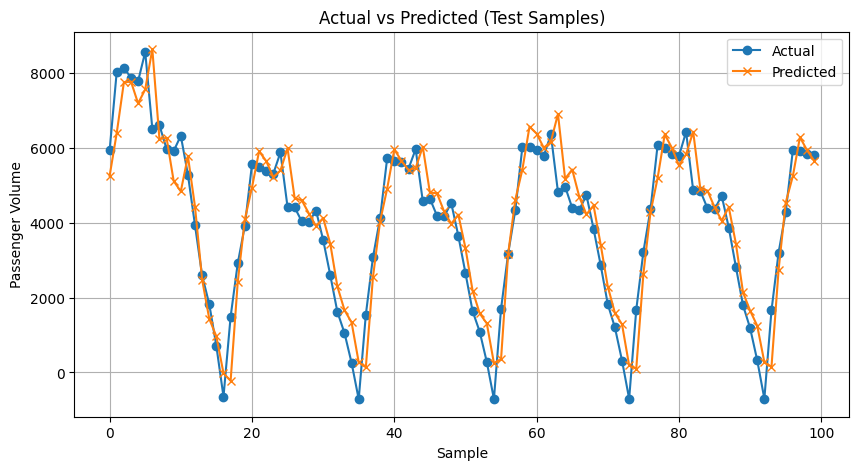

Evaluation completed in 0.31 seconds.
Plotting losses for weekend model...


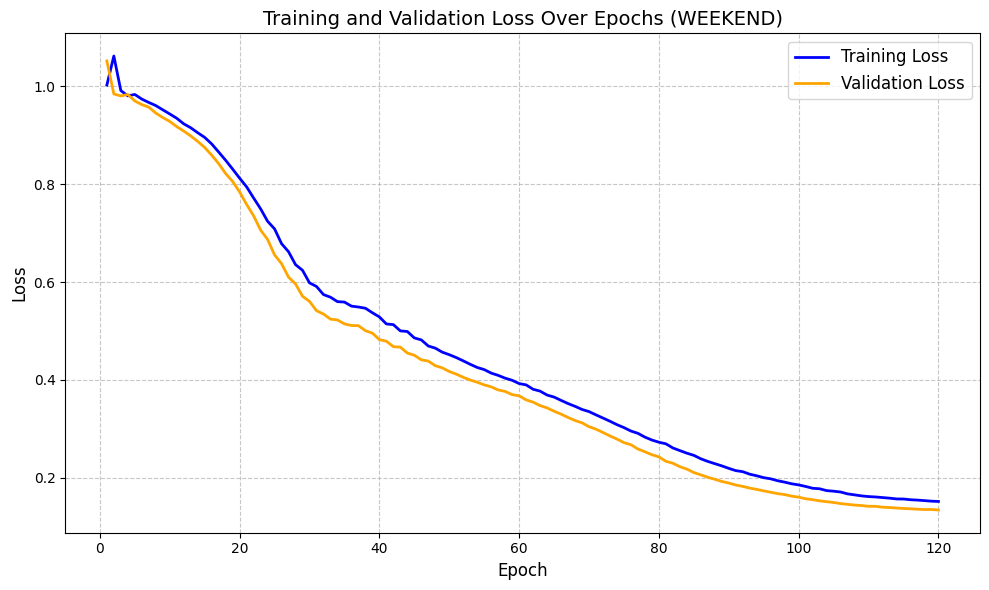

WEEKEND completed in 56.61 seconds.



In [49]:
train_weekday_data, train_weekend_data = process_passenger_volume(df_train)
test_weekday_data, test_weekend_data = process_passenger_volume(df_test)

weekday_model, scaler_X_wd_train, scaler_y_wd_train, scaler_X_wd_test, scaler_y_wd_test, node_mapping_wd = main(train_weekday_data, test_weekday_data, tag="weekday")
weekend_model, scaler_X_we, scaler_y_we, scaler_X_we_test, scaler_y_we_test, node_mapping_we = main(train_weekend_data, test_weekend_data, tag="weekend")

1. Creating graph structure...
 Graph creation completed in 4.95 seconds.
2. Preparing time series data...
Data Prepared: X shape torch.Size([219458, 12]), y shape torch.Size([219458, 2]), Stations: 181
Data Prepared: X shape torch.Size([111557, 12]), y shape torch.Size([111557, 2]), Stations: 181
Time series preparation completed in 2.68 seconds.
3. Splitting dataset...
 Data split completed in 0.01 seconds.
4. Initializing GNN model...
 Model initialization completed in 0.00 seconds.
5. Training model...


100%|██████████| 300/300 [10:23<00:00,  2.08s/it]


 Training completed in 623.18 seconds.
6. Evaluating model...
Test MSE: 4421779.0000
Test RMSE: 2102.8027
Test MAE: 1231.7375
Test MAPE: 39.74%
Test SMAPE: 19.78%
Test R²: 0.8422
Explained Variance Score: 0.8433
MASE could not be calculated (y_train not provided)


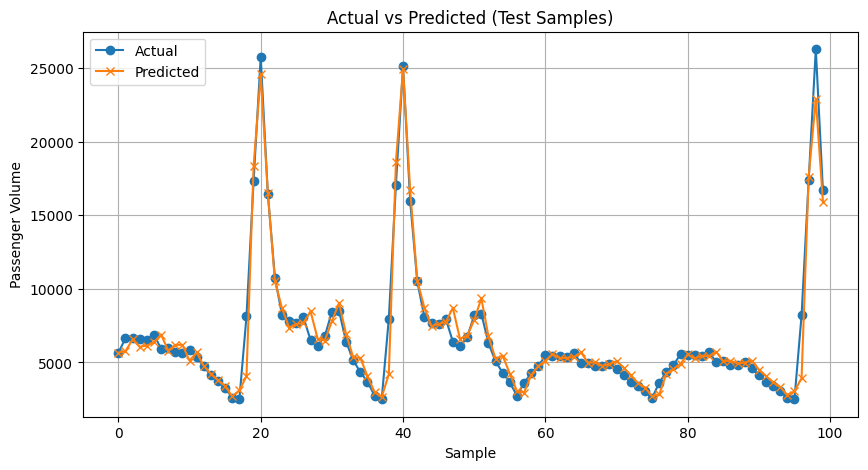

Evaluation completed in 0.73 seconds.
Plotting losses for all_variable model...


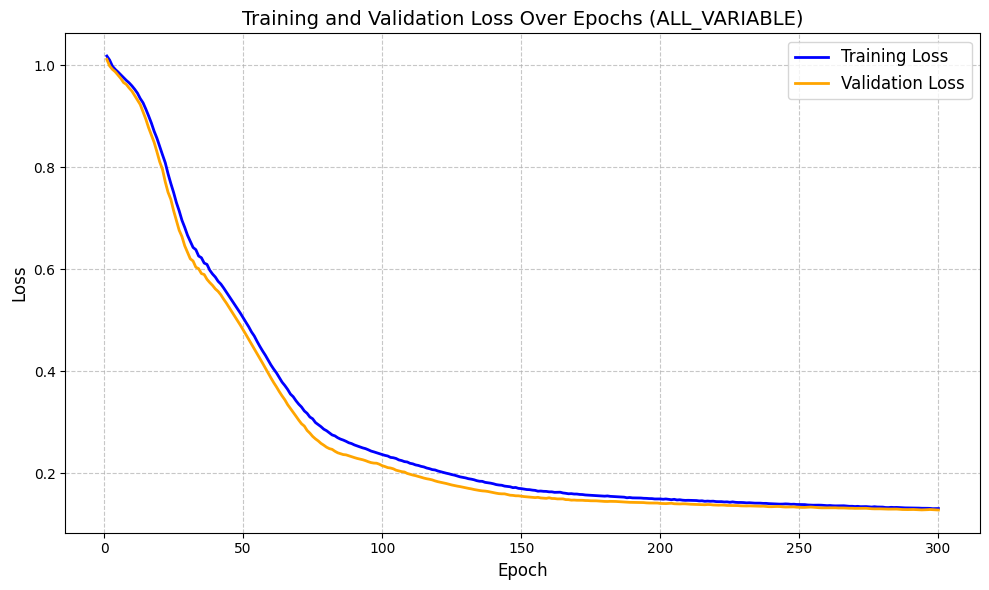

ALL_VARIABLE completed in 631.85 seconds.



In [53]:
df_train_clean_variable = process_passenger_volume(df_train, False)
df_test_clean_variable = process_passenger_volume(df_test, False)
all_model, scaler_X_train, scaler_y_train, scaler_X_test, scaler_y_test, node_mapping = main(df_train_clean_variable, df_test_clean_variable, tag="all_variable")